Preparing models for 2 different approaches: tree models and neural networks.
Can bring in the latter after forming some initial hypotheses about how samples are clustered.

Input Data Files:
in ./input_data_files/
- 18Sv4 and 18Sv9 asv counts
- pr2 taxonomy which also integrates the Mixoplankton Database (Mitra et al 2023)
- exclude_samples.txt, samples to filter out of analysis
- new 18Sv4 and 18Sv9 taxonomies on pr2 5.0.0
- metadata file containing "predictor" sample features

outputs of this notebook:
- new frequency tables for individual asvs, individual species, and individual functional types. each formatted as such: the samples are rows/observations and the asvs are the "response" features. 
- additional response features: per sample ASV diversity scores, or diversity scores within particular categories.
- "predictor" tables subset from the metadata file, include only the allowed samples and have data for all included samples. there may be cases of NA... not sure how to resolve, may have to go col by col.

Protocols for data:
- [Main CalCofi page for protocols](https://calcofi.org/data/marine-ecosystem-data/e-dna/)
- [Protocols.io sample collection](https://www.protocols.io/view/noaa-calcofi-ocean-genomics-ncog-sample-collection-eq2lypdorlx9/v1)
- [Protocols.io DNA extraction](https://www.protocols.io/view/sterivex-dna-extraction-x54v9m1y4g3e/v2)
- [Protocols.io PCR library prep & barcoding](https://www.protocols.io/view/amplicon-library-preparation-bp2l6b4j5gqe/v1) (primers used are listed here; "quantify with the qubit" (fluorometric... so it can measure amount of DNA but not quantify sequences))
    - [PR2 primer database, try and find them](https://app.pr2-primers.org/pr2-primers/)
- [QIIME protocols on allenlab github & the other data folder](https://github.com/allenlab/QIIME2_18Sv4_ASV_protocol)

### **Reading in input files**

In [1]:
import pandas as pd
import numpy as np

In [2]:
#any functions required by other notebooks have been moved here
#reimport when changing functions
from helper_functions import proportional_frequencies, shannon_index, asv_richness

In [3]:
raw_asv_freqs_18Sv9 = pd.read_csv("input_data_files/NCOG_18sV9_asv_count_tax_S.tsv", sep = "\t", index_col = 0)
raw_asv_freqs_18Sv4 = pd.read_csv("input_data_files/NCOG_18sV4_asv_count_tax.tsv", sep = "\t", index_col = 0)

asv_taxonomies_18Sv9 = pd.read_csv("input_data_files/18Sv9_pr2_5.0.0_classifications.tsv", sep = "\t", index_col = 0)
asv_taxonomies_18Sv4 = pd.read_csv("input_data_files/18Sv4_pr2_5.0.0_classifications.tsv", sep = "\t", index_col = 0)

pr2_taxonomies = pd.read_csv("input_data_files/pr2_version_5.0.0_taxonomy.tsv", sep = "\t")

samples_to_exclude = pd.read_csv("input_data_files/exclude_samples.txt", skiprows=2)
sample_metadata = pd.read_csv("input_data_files/NCOG_sample_log_DNA_stvx_meta_2014-2020.csv", index_col = 0)

### **Filter out asv counts and rescale to proportions after removing S. pombe**

In [4]:
def sample_mask(samples):
    """Selects only the columns which correspond to valid sample IDs."""
    return [col[0] == "X" and col[1:7].isdigit() and col not in samples_to_exclude for col in samples]

#18Sv4 and v9 do not have the same number of observations (samples).
sample_mask_18Sv4 = sample_mask(raw_asv_freqs_18Sv4.columns)
sample_mask_18Sv9 = sample_mask(raw_asv_freqs_18Sv9.columns)

len(sample_mask_18Sv9), sum(sample_mask_18Sv9),\
len(sample_mask_18Sv4), sum(sample_mask_18Sv4)

(1542, 1486, 1203, 1145)

In [5]:
#use asv taxonomies to find s pombe and remove it
def standard_mask(asv_taxonomies):
    """Returns a row mask excluding ASVs identified as internal standard Schizosaccharomyces pombe."""
    return ["pombe" not in taxon for taxon in asv_taxonomies["Taxon"]]

standard_mask_18Sv9 = standard_mask(asv_taxonomies_18Sv9)
standard_mask_18Sv4 = standard_mask(asv_taxonomies_18Sv4)
len(standard_mask_18Sv9), sum(standard_mask_18Sv9),\
len(standard_mask_18Sv4), sum(standard_mask_18Sv4)

(50408, 50407, 34498, 34496)

In [6]:
#apply row and column masks to each table, then scale proportionally along columns for proportional asv frequencies

asv_freqs_18Sv4 = raw_asv_freqs_18Sv4.loc[standard_mask_18Sv4, sample_mask_18Sv4].apply(
    proportional_frequencies, axis = 0)
asv_freqs_18Sv9 = raw_asv_freqs_18Sv9.loc[standard_mask_18Sv9, sample_mask_18Sv9].apply(
    proportional_frequencies, axis = 0)
asv_freqs_18Sv9.shape, asv_freqs_18Sv4.shape

((50407, 1486), (34496, 1145))

In [7]:
#only 1% of the cells in both tables have a nonzero value, should only expect useful data by aggregating into
#either species or MFTs... calculate per sample diversity scores for each
#since it's the species or MFT proportions that are going to be the "response features", i don't have to transpose just yet

sum(sum(asv_freqs_18Sv4.values != 0)) / (asv_freqs_18Sv4.index.size * asv_freqs_18Sv4.columns.size),\
sum(sum(asv_freqs_18Sv9.values != 0)) / (asv_freqs_18Sv9.index.size * asv_freqs_18Sv9.columns.size)

(0.014492155536291532, 0.01549514809477769)

### **Environmental feature tables for 18Sv4 and 18Sv9**

Since there's different numbers of samples in each table, these won't be exactly the same.

LightGBM can handle missing values so I'll leave them in.

Not all the metadata is included in the main metadata file. Can import the ones that aren't here (example: "region" category for stations (upwelling region, etc))

In [8]:
#change index so it matches columns of the frequency tables. guessing that qiime adds the X to avoid numerical var names
sample_metadata.index = ["X" + sample_id for sample_id in sample_metadata.index]

In [9]:
#Columns that contain environmental data about a sample-- not just IDs or combos of other variables.
#variables where you wouldn't expect this to make a difference but if it does it'll be good to know: Cast_Type, Cardinal_Sta
#keep lat and long as floats, for tree regression cutoffs
useful_metadata = ["Cast_Type","Cardinal_Sta",
                   "Lat_Dec", "Lon_Dec", 
                   "Bottle_Depth", 
                   "T_degC", 
                   "Salnty", 
                   "STheta", "O2ml_L","PO4ug","SiO3ug","NO3ug","NH3ug","ChlorA","Phaeop",
                   "RecInd","MLD_Sigma"]

#not all the samples have metadata; drop the ones that don't.
samples_w_data_18Sv4 = asv_freqs_18Sv4.columns[[sample in sample_metadata.index for sample in asv_freqs_18Sv4.columns]]
samples_w_data_18Sv9 = asv_freqs_18Sv9.columns[[sample in sample_metadata.index for sample in asv_freqs_18Sv9.columns]]


In [10]:
for sample in asv_freqs_18Sv4.columns:
    if sample not in sample_metadata.index:
        print(sample)
for sample in asv_freqs_18Sv9.columns:
    if sample not in sample_metadata.index:
        print(sample)
#sum([sample in sample_metadata.index for sample in asv_freqs_18Sv4.columns])

X201904_086.7_035.0_19
X201904_086.7_035.0_19


In [11]:
#transform the date and time variables: 
#date should be year/month/season (see how many boosting trees end up splitting on month)
#should these be discrete? does lightgbm treat discrete ints differently from categorical strings?
def split_date(date_series):
    """Takes a series of (M)M/DD/YYYY objects and returns 3 series of year, month, date."""
    finished_variables = {"year":[],"month":[],"season":[]}
    seasons = ["winter", "spring", "summer", "fall"]
    for date in date_series:
        if type(date) == float and np.isnan(date):
            finished_variables["year"].append(np.nan)
            finished_variables["month"].append(np.nan)
            finished_variables["season"].append(np.nan)
        else:
            month, day, year = date.split("/")
            finished_variables["year"].append(int(year))
            finished_variables["month"].append(int(month))
            season_index = (int(month) % 12) // 3 #0, 1, 2, 3
            finished_variables["season"].append(seasons[season_index])
    return pd.DataFrame(finished_variables, index = date_series.index)

timevars_18Sv4 = split_date(sample_metadata.loc[samples_w_data_18Sv4, "Date"])
timevars_18Sv9 = split_date(sample_metadata.loc[samples_w_data_18Sv9, "Date"])

In [12]:
#convert time to minutes since 0000 
def time_to_mins(time):
    """Converts a H:MM, HH:MM, or (H)H:MM:SS string to "minutes since 0000". If time is nan, return nan."""
    if type(time) == float and np.isnan(time):
        return time
    hhmmss = time.split(":")
    return int(hhmmss[0]) * 60 + int(hhmmss[1]) #ignore seconds
        
timevars_18Sv4["Mins_since_0000"] = [time_to_mins(time) for time in sample_metadata.loc[samples_w_data_18Sv4,"Time"]]
timevars_18Sv9["Mins_since_0000"] = [time_to_mins(time) for time in sample_metadata.loc[samples_w_data_18Sv9,"Time"]]

In [13]:
#create environmental features dataframes
#join the time variables: by default a left join (the final table's index will be env_features's index), index on index
env_features_18Sv4 = sample_metadata.loc[samples_w_data_18Sv4, useful_metadata].join(timevars_18Sv4)
env_features_18Sv9 = sample_metadata.loc[samples_w_data_18Sv9, useful_metadata].join(timevars_18Sv9)

In [14]:
with pd.option_context("display.max_colwidth", None, "display.max_columns", None):
    display(env_features_18Sv4)

,Cast_Type,Cardinal_Sta,Lat_Dec,Lon_Dec,Bottle_Depth,T_degC,Salnty,STheta,O2ml_L,PO4ug,SiO3ug,NO3ug,NH3ug,ChlorA,Phaeop,RecInd,MLD_Sigma,year,month,season,Mins_since_0000
X201402_086.7_033.0_10,Prodo,False,33.88950,-118.49250,10.0,14.652000,33.495701,24.888700,5.661,0.48,4.46,1.80,0.51,1.461,0.427,3.0,24.152739,2014.0,2.0,winter,1161.0
X201402_086.7_033.0_22,Prodo,False,33.88950,-118.49250,22.0,14.619000,33.494900,24.895889,5.624,0.50,4.59,1.80,0.62,1.333,0.417,3.0,24.152739,2014.0,2.0,winter,1161.0
X201402_090.0_037.0_10,Ros,True,33.18017,-118.39332,10.0,15.544000,33.530701,24.721359,5.822,0.34,2.54,0.00,0.01,0.362,0.097,3.0,13.239982,2014.0,2.0,winter,122.0
X201402_090.0_037.0_30,Ros,True,33.18017,-118.39332,30.0,14.020000,33.443100,24.982420,5.748,0.48,3.31,1.40,0.02,1.489,0.426,3.0,13.239982,2014.0,2.0,winter,122.0
X201402_090.0_053.0_10,Ros,True,32.65117,-119.48417,10.0,14.460000,33.290100,24.770920,5.897,0.37,2.37,0.10,0.05,0.466,0.122,3.0,21.755340,2014.0,2.0,winter,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X202010_093.3_050.0_10,NaN,False,32.17972,-118.89242,10.0,20.429001,33.686600,23.649481,5.350,0.14,1.05,0.18,NaN,0.263,0.103,NaN,10.429259,2020.0,10.0,fall,1102.0
X202010_093.3_050.0_30,NaN,False,32.17972,-118.89242,29.0,15.711000,33.455700,24.627911,5.594,0.36,2.67,0.93,NaN,1.019,0.542,NaN,10.429259,2020.0,10.0,fall,1102.0
X202010_093.3_090.0_10,Ross,False,30.84673,-121.59022,10.0,19.943001,33.251400,23.445560,5.388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.173782,2020.0,10.0,fall,1163.0
X202010_093.3_090.0_75,Ross,False,30.84673,-121.59022,75.0,13.073000,32.908600,24.763290,6.186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.173782,2020.0,10.0,fall,1163.0


### **Collate species frequencies and MFT frequencies into response features**

Can also take per sample diversity scores of relevant species as an additional feature.

In [15]:
#e.g. tiarina sp. is NOT just a generic "tiarina". it's a specific cluster of sequences. there could be another species
#is not that one and has a different trophic type. so it still make sense to match by species.
pr2_taxonomies.loc[
    ["sp" in pr2_taxonomies.loc[index, "species"]
     and type(pr2_taxonomies.loc[index, "mixoplankton"]) == str 
     for index in pr2_taxonomies.index]
,["species", "mixoplankton"]]

,species,mixoplankton
3152,Pterosperma_cristatum,CM
45376,Tiarina_sp.,eSNCM
45882,Spirotontonia_sp.,GNCM
46002,Gonyaulax_spinifera,CM
46058,Coolia_sp.,CM
46137,Barrufeta_resplendens,CM
46138,Bispinodinium_angelaceum,CM
46164,Lepidodinium_sp.,CM
46223,Nematodinium_sp.,CM
46264,Blastodinium_sp.,CM


In [16]:
#add the mixo column to each taxonomies object
#pr2_mft = pr2_taxonomies["mixoplankton"]
#pr2_mft.index = pr2_taxonomies["species"]
#pr2_mft.name = "MFT"

pr2_mft = pr2_taxonomies["mixoplankton"]
pr2_mft.index = pr2_taxonomies["species"].values
pr2_mft.name = "MFT"

asv_taxonomies_18Sv4["most_specific_name"] = asv_taxonomies_18Sv4["Taxon"].apply(lambda x : x.strip(";").split(";")[-1])
asv_taxonomies_18Sv9["most_specific_name"] = asv_taxonomies_18Sv9["Taxon"].apply(lambda x : x.strip(";").split(";")[-1])

asv_taxo_mft_18Sv4 = asv_taxonomies_18Sv4.join(pr2_mft, on="most_specific_name").loc[asv_freqs_18Sv4.index]
asv_taxo_mft_18Sv9 = asv_taxonomies_18Sv9.join(pr2_mft, on="most_specific_name").loc[asv_freqs_18Sv9.index]

In [17]:
#v9 vs. v4: which has more ASVs and higher confidence on classifications? that may vary!
display(asv_taxo_mft_18Sv4.loc[ [mft == "GNCM" for mft in asv_taxo_mft_18Sv4["MFT"]] ])
display(asv_taxo_mft_18Sv9.loc[ [mft == "GNCM" for mft in asv_taxo_mft_18Sv9["MFT"]] ])

,Taxon,Confidence,most_specific_name,MFT
Feature.ID,,,,
060dd2edd76a5d6438877037bf434f89,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.998480,Spirotontonia_sp.,GNCM
0726c31f1edc57782c5f1d0298a9405d,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.954496,Pseudotontonia_simplicidens,GNCM
10e5f49f7f0ba38a2315fa0cf1d9047a,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.978661,Pseudotontonia_simplicidens,GNCM
1fd9139ba70c4960568515186e739719,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.751422,Pseudotontonia_simplicidens,GNCM
4827f0c16d707123cd741f481dbd29c9,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.980069,Pseudotontonia_simplicidens,GNCM
5f08d10ff8f5aa9176c2eb350dfdb494,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.999735,Strombidium_capitatum,GNCM
660f154283b35ec0c146df61b47f85ff,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.851679,Strombidium_capitatum,GNCM
6689d55504861f52f17d349543f32eb1,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.926887,Laboea_strobila,GNCM
71e50e9f5f73e9405a8ab640525bae55,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.997365,Pseudotontonia_simplicidens,GNCM


,Taxon,Confidence,most_specific_name,MFT
Feature.ID,,,,
2abfa726d24e90ca55757ffc54fa69ac,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.999998,Strombidium_chlorophilum,GNCM
3fb5b10bb9245ace83ef6e068430669e,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.999657,Spirotontonia_sp.,GNCM
7bb04f20f6ad13b9ab18937da914f9b1,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.872572,Laboea_strobila,GNCM
7cc774ff1f66d9270f3f06b18e605b54,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.979331,Spirotontonia_sp.,GNCM
b734f84365fe560e470b162af90a2e96,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.999157,Spirotontonia_sp.,GNCM
d34e8e3f680dc45e7fbc7b64fb1362c9,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.965355,Spirotontonia_sp.,GNCM
ee1074fc2331d04d28c796cb16057e75,Eukaryota;TSAR;Alveolata;Ciliophora;Spirotrich...,0.962011,Spirotontonia_sp.,GNCM


In [18]:
asv_freqs_18Sv4.shape, asv_freqs_18Sv9.shape

((34496, 1145), (50407, 1486))

In [19]:
env_features_18Sv4.shape, env_features_18Sv9.shape

((1144, 21), (1485, 21))

In [20]:
#v4 has more species classified in CM and GNCM, v9 has more in pSNCM and eSNCM - interesting.
#from here on out, should keep doing the steps for v4 and v9
for mft in ["CM", "GNCM", "pSNCM", "eSNCM"]:
    print(
        asv_taxo_mft_18Sv4.loc[asv_taxo_mft_18Sv4["MFT"] == mft].shape,
        asv_taxo_mft_18Sv9.loc[asv_taxo_mft_18Sv9["MFT"] == mft].shape,
    )
#test.loc[ ["Dinophysis_ac" in name for name in test["most_specific_name"] ] ]

(470, 4) (450, 4)
(22, 4) (7, 4)
(4, 4) (15, 4)
(84, 4) (158, 4)


### **Extracting dino-only species proportions and MFT proportions**

Should be able to use the same methods as for all species.

### **Alpha diversity & "composability" of pandas & helper functions**

Want to apply different diversity scores to different datasets? Generate dataset by transforming the basic data then apply desired function. Mix & match different row selector lists & apply functions to resulting subsets.

Faith PD over ASVs for: dino ASVs. (Genetic saturation: distance trees not as effective for more distantly related organisms)
Shannon over ASVs for: all ASVs, dino ASVs.

Shannon diversity function defined in "helper_functions.py".

In [21]:
#can start doing some introductory analysis
#make a scatterplot of all ASV shannon, dino shannon, and dino CM shannon against... 
#idk for the first two it should be pan-dino proportion of all ASVs and for dino CM it can be CM proportion of all dinos
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
#selects only ASVs which were classified (Naive Bayes) as CM dinoflagellate species.
dino_mask_18Sv4 = ["Dinoflagellata" in asv_taxo_mft_18Sv4.loc[asv, "Taxon"] for asv in asv_taxo_mft_18Sv4.index]
CM_mask_18Sv4 = asv_taxo_mft_18Sv4["MFT"] == "CM"

dino_mask_18Sv9 = ["Dinoflagellata" in asv_taxo_mft_18Sv9.loc[asv, "Taxon"] for asv in asv_taxo_mft_18Sv9.index]
CM_mask_18Sv9 = asv_taxo_mft_18Sv9["MFT"] == "CM"

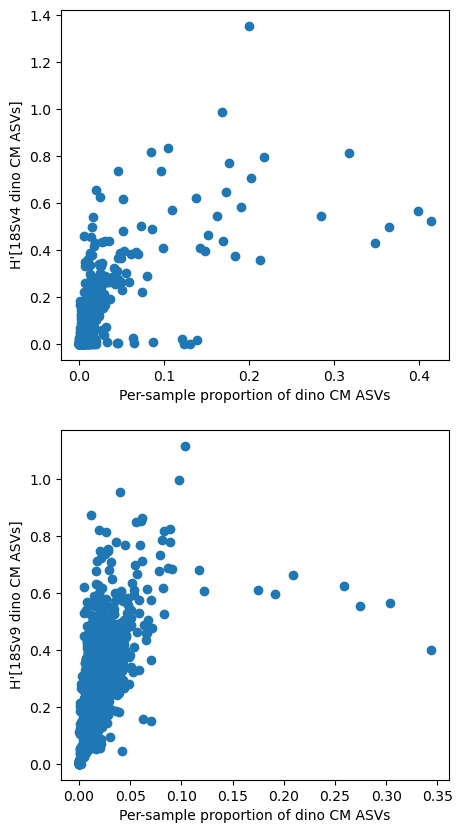

In [24]:
#if ASV proportion of the total sample corresponds with biomass, then I shouldn't ever have "proportion of subset"
#as the x axis
#customizability problems: the only real solution is not trying to create anything ahead of time and just having
#standard procedures for generating all required features from the basic "asv_freqs" and "asv_taxo_mft" using
#pandas methods and helper methods

fig, ax = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(5)

ax[0].scatter(
    #Y axis: shannon index within the subset "dinoflagellate CMs": select dino ASVs, redo proportional frequencies,
    #select CMs, then shannon? ok wow this worked
    #y=dino_eco_features_18Sv4["dino_CM_shannon"],
    y=asv_freqs_18Sv4.loc[dino_mask_18Sv4]
        .apply(proportional_frequencies, axis = 0)
        .loc[dino_mask_18Sv4 and CM_mask_18Sv4]
        .apply(shannon_index),
    #X axis: summed ASV per-sample proportions (sum along column, collapse rows) for "dinoflagellate CMs"
    x=asv_freqs_18Sv4.loc[dino_mask_18Sv4 and CM_mask_18Sv4].apply(sum, axis = 0)
)
ax[0].set_ylabel("H'[18Sv4 dino CM ASVs]")
ax[0].set_xlabel("Per-sample proportion of dino CM ASVs")

ax[1].scatter(
    y=asv_freqs_18Sv9.loc[dino_mask_18Sv9]
        .apply(proportional_frequencies, axis = 0)
        .loc[dino_mask_18Sv9 and CM_mask_18Sv9]
        .apply(shannon_index), 
    x=asv_freqs_18Sv9.loc[dino_mask_18Sv9 and CM_mask_18Sv9].apply(sum, axis = 0))
ax[1].set_ylabel("H'[18Sv9 dino CM ASVs]")
ax[1].set_xlabel("Per-sample proportion of dino CM ASVs")

plt.show()

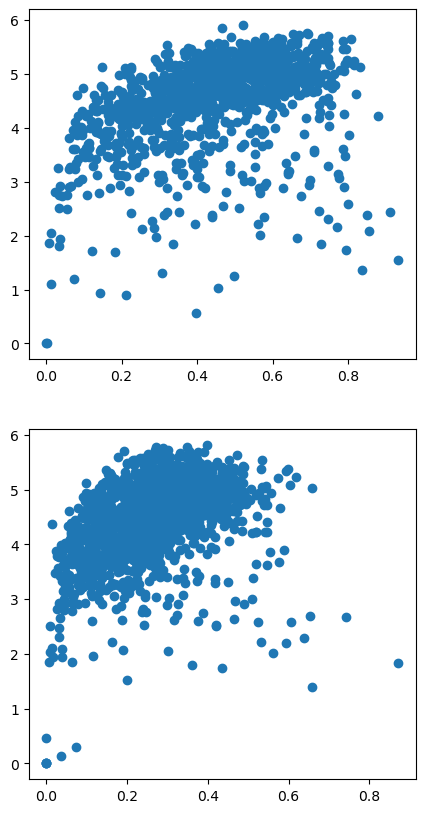

In [25]:
fig, ax = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(10)

ax[0].scatter(
    #Y axis: Shannon index of dinos only, with proportions rescaled so dino freqs sum to 1.
    y=asv_freqs_18Sv4.loc[dino_mask_18Sv4]
        .apply(proportional_frequencies, axis = 0)
        .apply(shannon_index, axis = 0), 
    #X axis: per-sample summed proportion for dino ASVs.
    x=asv_freqs_18Sv4.loc[dino_mask_18Sv4].apply(sum, axis = 0)
)
ax[1].scatter(
    y=asv_freqs_18Sv9.loc[dino_mask_18Sv9]
        .apply(proportional_frequencies, axis = 0)
        .apply(shannon_index, axis = 0), 
    x=asv_freqs_18Sv9.loc[dino_mask_18Sv9].apply(sum, axis = 0)
)
plt.show()

### Species richness (number of ASVs) vs proportion of ASVs

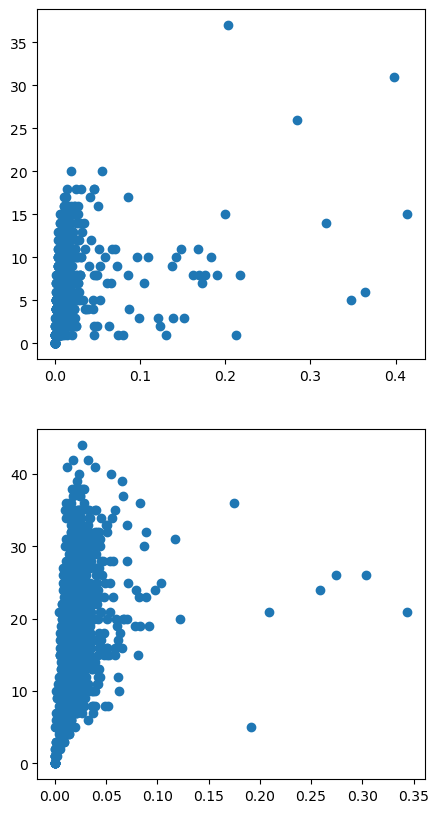

In [27]:
fig, ax = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(10)

#species richness = # nonzero ASVs *per column* in selected rows

ax[0].scatter(
    #Y axis: per sample ASV richness (# nonzero ASVs) of dino CMs
    y=asv_freqs_18Sv4.loc[dino_mask_18Sv4 and CM_mask_18Sv4].apply(asv_richness, axis = 0), 
    #X axis: per sample summed proportion of dino CMs
    x=asv_freqs_18Sv4.loc[dino_mask_18Sv4 and CM_mask_18Sv4].apply(sum, axis = 0)
)
ax[1].scatter(
    y=asv_freqs_18Sv9.loc[dino_mask_18Sv9 and CM_mask_18Sv9].apply(asv_richness, axis = 0), 
    x=asv_freqs_18Sv9.loc[dino_mask_18Sv9 and CM_mask_18Sv9].apply(sum, axis = 0)
)
plt.show()

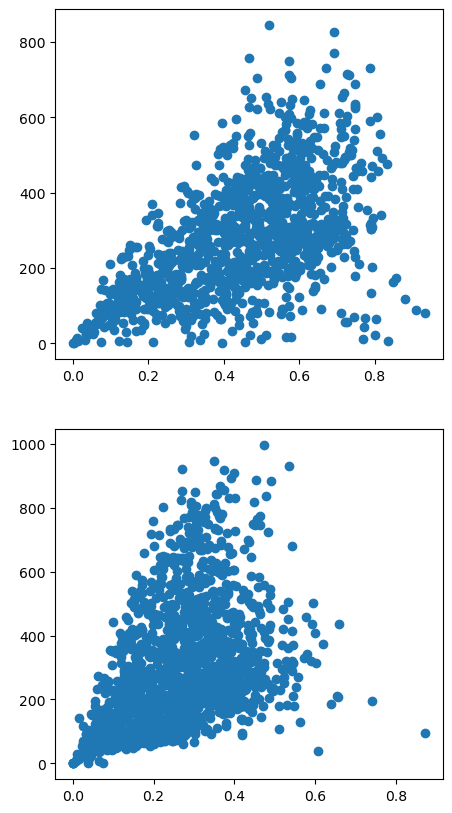

In [28]:
#all asv shannon not that useful honestly
fig, ax = plt.subplots(2)
fig.set_figwidth(5)
fig.set_figheight(10)

ax[0].scatter(
    #Y axis: per sample ASV richness (# nonzero ASVs) of dino CMs
    y=asv_freqs_18Sv4.loc[dino_mask_18Sv4].apply(asv_richness, axis = 0), 
    #X axis: per sample summed proportion of dino CMs
    x=asv_freqs_18Sv4.loc[dino_mask_18Sv4].apply(sum, axis = 0)
)
ax[1].scatter(
    y=asv_freqs_18Sv9.loc[dino_mask_18Sv9].apply(asv_richness, axis = 0), 
    x=asv_freqs_18Sv9.loc[dino_mask_18Sv9].apply(sum, axis = 0)
)
plt.show()

### Using Chlorophyll for biomass

First evidence so far for negative correlation of dino diversity and biomass... except it's not even dino biomass.
check datazoo for peridinin. env feature "Phaeop" = phaeophytin, 2ndary pigment for diatoms.

In [33]:
env_features_18Sv4["ChlorA"].shape,\
asv_freqs_18Sv4.loc[dino_mask_18Sv4].shape

((1144,), (19821, 1145))

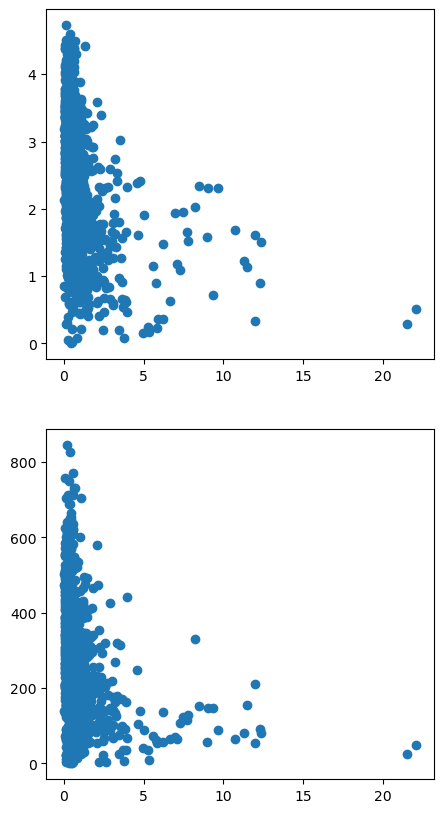

In [34]:
fig, ax = plt.subplots(2)

fig.set_figheight(10)
fig.set_figwidth(5)

ax[0].scatter(
    y = asv_freqs_18Sv4.loc[dino_mask_18Sv4, env_features_18Sv4.index].apply(shannon_index, axis = 0),
    x = env_features_18Sv4["ChlorA"] #chlor a, associates with all photosynthetic organisms
)

ax[1].scatter(
    y = asv_freqs_18Sv4.loc[dino_mask_18Sv4, env_features_18Sv4.index].apply(asv_richness, axis = 0),
    x = env_features_18Sv4["ChlorA"] #chlor a, associates with all photosynthetic organisms
)

plt.show()

### **outputs and next steps**

want to use the GBM to... if it can't fully summarize the relationship by itself, it could at least point to which variables would make the most interesting scatterplots, especially for comparing v9 and v4.

decide what to export and why in order to perform the above 4 tests and whatever other tests you want to do.

export env_features, asv_taxo_mft, and asv_freqs. can compose them with helper functions into desired response variables. 

In [29]:
asv_freqs_18Sv4.to_csv("_out_asv_freqs_18Sv4.tsv", sep = "\t")
asv_freqs_18Sv9.to_csv("_out_asv_freqs_18Sv9.tsv", sep = "\t")
asv_taxo_mft_18Sv4.to_csv("_out_asv_taxo_mft_18Sv4.tsv", sep = "\t")
asv_taxo_mft_18Sv9.to_csv("_out_asv_taxo_mft_18Sv9.tsv", sep = "\t")
env_features_18Sv4.to_csv("_out_env_features_18Sv4.tsv", sep = "\t")
env_features_18Sv9.to_csv("_out_env_features_18Sv9.tsv", sep = "\t")

In [ ]:
assert(False)

**cool dataframe properties**

In [60]:
row_mask = asv_taxo_mft_18Sv4["most_specific_name"] == "Eukaryota"
asv_freqs_18Sv4.loc[ row_mask ].apply(sum, axis = 0)

X201402_086.7_033.0_10    0.031782
X201402_086.7_033.0_22    0.010655
X201402_090.0_037.0_10    0.019532
X201402_090.0_037.0_30    0.021966
X201402_090.0_053.0_10    0.001181
                            ...   
X202010_093.3_050.0_10    0.005003
X202010_093.3_050.0_30    0.002022
X202010_093.3_090.0_10    0.010653
X202010_093.3_090.0_75    0.001622
X202010_093.4_026.4_10    0.005931
Length: 1145, dtype: float64

In [41]:
np.zeros((2,3))

array([[0., 0., 0.],
       [0., 0., 0.]])

In [32]:
pd.DataFrame({"A":[1,2,3]}, index=[0,1,2]).apply(lambda x: [x+1, x+2, x+3], axis=1)

0    [[2], [3], [4]]
1    [[3], [4], [5]]
2    [[4], [5], [6]]
dtype: object

In [81]:
pd.Series(["a;a","b;b","c;c"]).map(lambda x : x.split(";")[-1] )

0    a
1    b
2    c
dtype: object

In [82]:
#"on" matches a certain column on the left database to the index on the right
#(default) left join means the final index is the left database's index
pd.DataFrame({"A":[2,3,2], "B":["C", 4,4]}, index = [0,1,2]).join(
    pd.DataFrame({"C":[2]}, index=[2]), on="A", how = "right"
)

,A,B,C
0,2,C,2
2,2,4,2


In [83]:
#"on" matches a certain column on the left database to the index on the right
#(default) left join means the final index is the left database's index
pd.DataFrame({"A":[2,3,2], "B":["C", 4,4]}, index = [0,1,2]).join(
    pd.DataFrame({"C":[2]}, index=[2]), on="A", how = "left"
)

,A,B,C
0,2,C,2.0
1,3,4,NaN
2,2,4,2.0


In [44]:
asv_taxo_mft_18Sv4.shape, asv_taxo_mft_18Sv9.shape

((34496, 2), (50407, 2))

In [47]:
asv_taxo_mft_18Sv9

,Taxon,Confidence
Feature.ID,,
0001599454f2da26e5aee125d7023d4d,Eukaryota,0.986045
0002f43bb3f3bf8b6f3d636b3c672ef2,Eukaryota;TSAR;Stramenopiles;Gyrista;Chrysophy...,0.999992
00056eb5e7001738958dd0312045ee37,Eukaryota;Obazoa;Opisthokonta;Metazoa;Arthropo...,0.999987
0007c76e072d3fdb58a23b0bfd1280ba,Eukaryota;Archaeplastida;Chlorophyta;Chlorophy...,0.989461
00084d8d6fe9f9e43abbbb933ba5b2d4,Eukaryota;TSAR;Alveolata;Dinoflagellata;Syndin...,0.999317
...,...,...
ffeedaa8ec2cfa5987319a9682cbb058,Eukaryota;Obazoa;Opisthokonta;Metazoa;Arthropo...,0.999936
fff356fd8132f5fe3a0c21b9390a71d4,Eukaryota,0.984101
fff59edf14ce1635fa136e0c871dcfad,Eukaryota,0.991014
